In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [3]:
!git clone https://github.com/tensorflow/probability

Cloning into 'probability'...
remote: Counting objects: 3647, done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 3647 (delta 124), reused 177 (delta 102), pack-reused 3408
Receiving objects: 100% (3647/3647), 9.81 MiB | 14.03 MiB/s, done.
Resolving deltas: 100% (2575/2575), done.


In [4]:
cd probability

/content/probability


In [0]:
!python setup.py build

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import itertools
import pdb
from sklearn.utils import shuffle
from sklearn.metrics import average_precision_score, roc_auc_score
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tf.logging.set_verbosity(tf.logging.INFO)
tf.set_random_seed(0)

In [0]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data/MNIST_data/", one_hot=False)

train_data = mnist.train.images.astype(float)
train_labels = mnist.train.labels.astype(float)
from sklearn.utils import shuffle
train_data, train_labels = shuffle(train_data, train_labels, random_state=0)
numbers = []
for i in range(10):
    numbers.append(train_data[train_labels==i, :])

test_data = train_data[-100:]
test_labels = train_labels[-100:]

train_data = train_data[:-100]
train_labels = train_labels[:-100]

In [0]:
def make_encoder(z_size=2):  
  
    
    def encoder(x):
     
        encoder_net = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation=tf.nn.relu),
          tf.keras.layers.Dense(256, activation=tf.nn.relu),
          tf.keras.layers.Dense(2 * z_size, activation=None),
          ])
        net = encoder_net(x)

        return tfd.MultivariateNormalDiag(loc=net[..., :z_size], scale_diag=tf.nn.softplus(net[..., z_size:]))
    
    return encoder
    


def make_decoder(x_shape=784):
    
    def decoder(x):
      
      
        decoder_net = tf.keras.Sequential([
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dense(512, activation=tf.nn.relu),
          tf.keras.layers.Dense(x_shape, activation=None),
          ])
        net = decoder_net(x)
        return tfd.Independent(tfd.Bernoulli(logits=net), reinterpreted_batch_ndims=1)
    
    return decoder


def init_once(x, name):
  return tf.get_variable(name, initializer=x, trainable=False)

def make_arflow(z_dist, latent_size=2, n_flows=4, hidden_size=(512, 512), invert=False):
    chain = list(itertools.chain.from_iterable([
        tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_size)),
        tfb.Permute(init_once(np.random.permutation(latent_size), 'permute_%d' % i)),
    ] for i in range(n_flows)))
    return tfd.TransformedDistribution(distribution=z_dist, bijector=tfb.Chain(chain[:-1]))

def make_prior(z_size=2):
    return make_arflow(tfd.MultivariateNormalDiag(loc=tf.zeros([z_size], dtype=tf.float32), scale_diag = tf.ones([z_size], dtype=tf.float32)))


def get_batch(data_x, batch_size=100):
    batch_n = len(data_x) // batch_size
    for i in range(batch_n):
        batch_x = data_x[i * batch_size:(i + 1) * batch_size]
        yield batch_x
        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: 

epoch 0
elbo at 0 : -544.12994
elbo of random noise  -544.17615
elbo of adversarially perturbed noise:  -543.1131
elbo at 400 : -255.01463
epoch 1
elbo at 800 : -218.88014
epoch 2
elbo at 1200 : -217.97714
elbo at 1600 : -202.44473
epoch 3
elbo at 2000 : -209.50061
elbo of random noise  -927.557
elbo of adversarially perturbed noise:  3807.505
epoch 4
elbo at 2400 : -194.09967
epoch 5
elbo at 2800 : -197.16922
elbo at 3200 : -191.51518
epoch 6
elbo at 3600 : -193.41293
epoch 7
elbo at 4000 : -187.61755
elbo of random noise  -822.215
elbo of adversarially perturbed noise:  10915.263
epoch 8
elbo at 4400 : -193.6274
elbo at 4800 : -186.06026
epoch 9
elbo at 5200 : -193.39291
epoch 10
elbo at 5600 : -188.01613
elbo at 6000 : -187.00351
elbo of random noise  -609.3516
elbo of adversarially perturbed noise:  16279.986
epoch 11
elbo at 6400 : -187.97633
epoch 12
elbo at 6800 : -188.11493
epoch 13
elbo at 7200 : -189.90211
elbo at 7600 : -186.7534
epoch 14
elbo at 8000 : -180.19461
elbo of ra

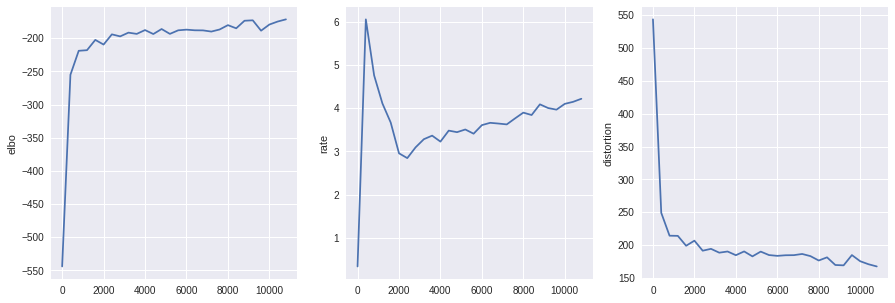

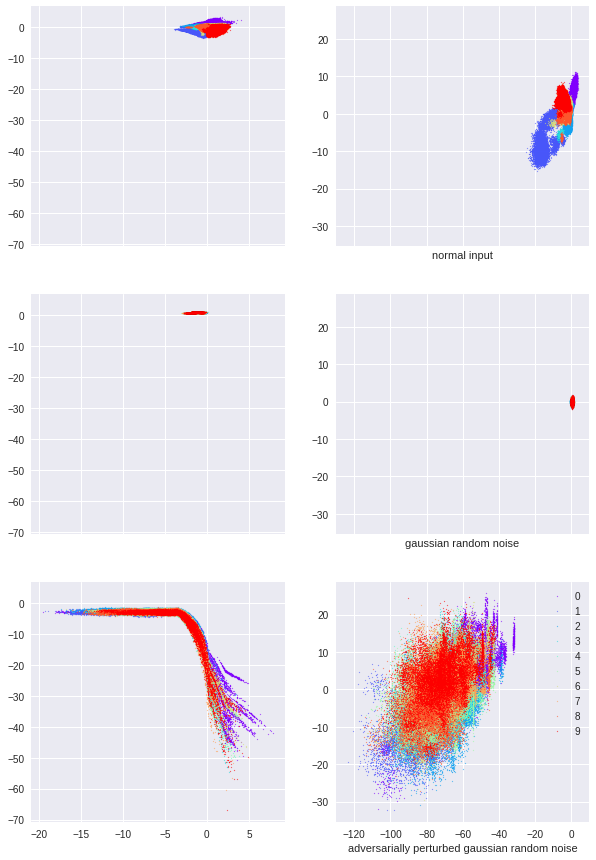

In [90]:

tf.reset_default_graph()
with tf.Graph().as_default() as g:
    input_layer = tf.placeholder(tf.float32, shape=[None, 784], name='x')
    
    
    encoder = make_encoder()
    decoder = make_decoder()
    latent_prior = make_prior()
        
    approx_posterior = encoder(input_layer)
    approx_posterior_sample = approx_posterior.sample(16)
    decoder_likelihood = decoder(approx_posterior_sample)
    
    distortion = -decoder_likelihood.log_prob(input_layer)
    rate = (approx_posterior.log_prob(approx_posterior_sample) - latent_prior.log_prob(approx_posterior_sample))
    elbo_local = -(rate + distortion)
    elbo = tf.reduce_mean(elbo_local)
    loss = -elbo
    
    
    
    gaussian_noise = tfd.Normal(loc=0.0, scale=1.0)
    gaussian_samples = gaussian_noise.sample(sample_shape=(100,784))
    
    # construct adversarially perturbed gaussian noise (rubbish exampels ) by FGSM
    gradients = tf.gradients(loss, input_layer)
    adv_normal_noise = gaussian_samples - 0.3*tf.sign(gradients)[0]     
    # I did not add adersarially perturbed inputs here because they don't have high ELBOs, contrary to adversarially perturbed noise
    # also we only use adversarially perturbed noise for our main experiments

    
    
   # for visualizations
 
    visualize_samples = approx_posterior.sample(100)     # how posterior looks like
    samples = [latent_prior.bijector.inverse(visualize_samples)]  # how posterior inversed? back to prior looks like
    samples.append(visualize_samples)


    optimizer = tf.train.AdamOptimizer(0.00001)
    train_op = optimizer.minimize(loss)

    tf.summary.scalar('loss', loss)
    summ_op = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./logs/train')
    saver = tf.train.Saver()
    init = tf.global_variables_initializer()
    g.finalize()

   
    
# train and visualize
with tf.Session(graph=g) as sess:
   
    train_writer.add_graph(g)
    
    step = 0
    elbos = []
    rates = []
    distortions = []
    global_step = []
    sess.run(init)

    for epoch in range(20):

        train_data = shuffle(train_data, random_state=0)
        print("epoch",str(epoch))

        for batch_x in get_batch(train_data, 100):
            # train
            feed_dict = {input_layer: batch_x}
            fetch_dict = {'elbo': elbo, 'distortion': distortion, 'rate': rate, 'train': train_op, 'summary': summ_op}

            result = sess.run(fetch_dict, feed_dict)
            # collect loss
            if step % 400 == 0:
                #train_writer.add_summary(result['summary'], step)
                global_step.append(step)
                elbos.append(result['elbo'])
                rates.append(np.mean(result['rate']))
                distortions.append(np.mean(result['distortion']))
                print("elbo at", step, ":", result['elbo'])
           
            if step % 2000 == 0:    # check ELBOs of out of distribution samples during training
                feed_dict = {input_layer: batch_x}
                fetch_dict = {'random_noise': gaussian_samples, 'adv_normal_noise':adv_normal_noise}
                results = sess.run(fetch_dict, feed_dict)
                
                random_noise =np.clip(results['random_noise'],0,1)
                perturbed_noise = results['adv_normal_noise']
                
                feed_dict = {input_layer: random_noise}
                fetch_dict = {'elbo':elbo}
                results = sess.run(fetch_dict, feed_dict)
                print("elbo of random noise ", results['elbo'])
                
                feed_dict = {input_layer: perturbed_noise}
                fetch_dict = {'elbo':elbo}
                results = sess.run(fetch_dict, feed_dict)
                print("elbo of adversarially perturbed noise: ", results['elbo'])   
            step += 1   
            
    # plot elbo, rate, distortion        
    f, axes = plt.subplots(1,3,figsize=(15,5))
    axes[0].plot(global_step,elbos)
    axes[0].set_ylabel('elbo')
    axes[1].plot(global_step,rates)
    axes[1].set_ylabel('rate')
    axes[2].plot(global_step,distortions)
    axes[2].set_ylabel('distortion')
    plt.show()
    

    # run digits from training distribution for visualization of latent space
    normal_results = []  
    random_numbers_results = []
    adv_numbers_results = []

    
    for num_array in numbers:   # collect visualizations for all the digits
        feed_dict = {input_layer: num_array[:100]}
        fetch_dict = {'samples': samples, 'random_noise': gaussian_samples, 'adv_normal_noise':adv_normal_noise}
        results = sess.run(fetch_dict, feed_dict)
        
        random_noise = np.clip(results['random_noise'],0,1)
        perturbed_noise = results['adv_normal_noise']
        num_results = results["samples"]    # visualization of normal points for one digit
        
        feed_dict = {input_layer: random_noise}
        fetch_dict = {'samples': samples}
        results = sess.run(fetch_dict, feed_dict)
        random_num_results = results["samples"]   # visualization of gaussian random noise for one digit

        feed_dict = {input_layer: perturbed_noise}
        fetch_dict = {'samples': samples}
        results = sess.run(fetch_dict, feed_dict)
        adv_num_results = results["samples"]   # visualization of adversarially perturbed noise for one digit


        normal_results.append(num_results)   
        random_numbers_results.append(random_num_results)
        adv_numbers_results.append(adv_num_results)
        

    # visualize latent of normal examples with color     
    f, arr = plt.subplots(3, 2, figsize=(10, 15), sharex='col', sharey='col')
    colors = cm.rainbow(np.linspace(0, 1, 10))

    for i in range(2):
        for num, c in zip(range(10), colors):
            X1 = normal_results[num][i]
            arr[0,i].scatter(X1[:, :100, 0], X1[:, :100, 1], s=1, color=c, label=num, alpha=0.5)
    arr[0,1].set_xlabel('normal input')        
    
    # visualize latent of random gaussian noise
    for i in range(2):
        for num, c in zip(range(10), colors):
            X1 = random_numbers_results[num][i]
            arr[1,i].scatter(X1[:, :100, 0], X1[:, :100, 1], s=1, color=c, label=num, alpha=0.5)
    arr[1,1].set_xlabel('gaussian random noise')           
   
    # visualize latent of adversarially perturbed normal noise with color
    for i in range(2):
        for num, c in zip(range(10), colors):
            X1 = adv_numbers_results[num][i]
            arr[2,i].scatter(X1[:, :100, 0], X1[:, :100, 1], s=1, color=c, label=num, alpha=0.5)
    arr[2,1].set_xlabel('adversarially perturbed gaussian random noise') 
    plt.legend()
    plt.show()

  
   
